# Bayesian calibration of a computer code

In this example we are going to compute the parameters of a computer model thanks to Bayesian estimation.

Let us denote $\underline y = (y_1, \dots, y_n)$ the observation sample, $\underline z = (f(x_1|\underline{\theta}), \ldots, f(x_n|\underline{\theta}))$ the model prediction, $p(y |z)$ the density function of observation $y$ conditional on model prediction $z$, and $\underline{\theta} \in \mathbb{R}^p$ the calibration parameters we wish to estimate.


The posterior distribution is given by Bayes theorem:

$$\pi(\underline{\theta} | \underline y) \quad \substack{~\\[0.5em]\displaystyle\propto\\\scriptstyle\underline{\theta}} \quad L\left(\underline y | \underline{\theta}\right) \times \pi(\underline{\theta})$$

(where $\substack{~\\[0.5em]\displaystyle\propto\\\scriptstyle\underline{\theta}}$
means "proportional to", regarded as a function of $\underline{\theta}$)
and is approximated here by the empirical distribution of the sample $\underline{\theta}^1, \ldots, \underline{\theta}^N$ generated by the Metropolis-Hastings algorithm. This means that any quantity characteristic of the posterior distribution (mean, variance, quantile, ...) is approximated by its empirical counterpart.



Our model (i.e. the compute code to calibrate) is a standard normal linear regression, where

$$y_i = \theta_1 + x_i \theta_2 + x_i^2 \theta_3 + \varepsilon_i$$

where $\varepsilon_i \stackrel{i.i.d.}{\sim} \mathcal N(0, 1)$
and we use a normal prior on $\underline{\theta}$:

$$\pi(\underline{\theta}) = \mathcal N(0 ; 100 I_3).$$

The following objects need to be defined in order to perform Bayesian calibration:

- The conditional density $p(y|z)$ must be defined as a probability distribution
- The computer model must be implemented thanks to the ParametricFunction class.
  This takes a value of $\underline{\theta}$ as input, and outputs the vector of model predictions $\underline z$,
  as defined above (the vector of covariates $\underline x = (x_1, \ldots, x_n)$ is treated as a known constant).
  When doing that, we have to keep in mind that $z$ will be used as the vector of parameters corresponding
  to the distribution specified for $p(y |z)$. For instance, if $p(y|z)$ is normal,
  this means that $z$ must be a vector containing the mean and variance of $y$
- The prior density $\pi(\underline{\theta})$ encoding the set of possible values for the calibration parameters,
  each value being weighted by its a priori probability, reflecting the beliefs about the possible values
  of $\underline{\theta}$ before consideration of the experimental data.
  Again, this is implemented as a probability distribution
- The Metropolis-Hastings algorithm that samples from the posterior distribution of the calibration parameters
  requires a vector $\underline{\theta}_0$ initial values for the calibration parameters,
  as well as the proposal laws used to update each parameter sequentially.


In [1]:
from __future__ import print_function
import openturns as ot
import math as m

In [2]:
# Number of covariates
covNum = 1
# Dimension of the observations
obsDim = 1
# Dimension of the vector of parameters to calibrate
paramDim = 3
# The number of obesrvations
obsSize = 10

- Define the observed inputs $x_i$

In [3]:
xmin = -2.
xmax = 3.
step = (xmax-xmin)/(obsSize-1)
rg = ot.RegularGrid(xmin, step, obsSize)
x_obs = rg.getVertices()
x_obs

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 description=[t] data=[[-2],[-1.44444],[-0.888889],[-0.333333],[0.222222],[0.777778],[1.33333],[1.88889],[2.44444],[3]]

In this model, we use a constant value of the parameter.

In [4]:
thetaPriorMean = [-3.,4.,1.]

- Define the vector of parameters matching each observation $\theta^i$.

- Define the parametric model $z = f(x,\theta)$ that associates each observation $x_i$ and values of the  parameters $\theta_i$ to the parameters of the distribution of the corresponding observation: here $z=(\mu, \sigma)$

In [5]:
fullModel = ot.SymbolicFunction(
    ['x1', 'theta1', 'theta2', 'theta3'], ['theta1+theta2*x1+theta3*x1^2','1.0'])
model = ot.ParametricFunction(fullModel, [0], x_obs[0])
model

class=FunctionImplementation name=Unnamed description=[theta1,theta2,theta3,y0,y1] evaluationImplementation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,theta1,theta2,theta3,y0,y1] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x1] values=[-2] input positions=[1,2,3] gradientImplementation=class=ParametricGradient evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,theta1,theta2,theta3,y0,y1] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x1] values=[-2] input positions=[1,2,3] hessianImplementation=class=ParametricHessian evaluation=class=ParametricEvaluation function=class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x1,theta1,theta2,theta3,y0,y1] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[x1,theta1,theta2,theta3] outputVariablesNames=[y0,y1] formulas=[theta1+theta2*x1+theta3*x1^2,1.0] parameters positions=[0] parameters=class=PointWithDescription name=Unnamed dimension=1 description=[x1] values=[-2] input positions=[1,2,3]

- Define the observation noise.

In [6]:
ot.RandomGenerator.SetSeed(0)
noiseStandardDeviation = 1.
noise = ot.Normal(0,noiseStandardDeviation)
noiseSample = noise.getSample(obsSize)
noiseSample

class=Sample name=Normal implementation=class=SampleImplementation name=Normal size=10 dimension=1 description=[X0] data=[[0.608202],[-1.26617],[-0.438266],[1.20548],[-2.18139],[0.350042],[-0.355007],[1.43725],[0.810668],[0.793156]]

- Define the vector of observations $y_i$

In [7]:
y_obs = ot.Sample(obsSize,1)
for i in range(obsSize):
    model.setParameter(x_obs[i])
    y_obs[i,0] = model(thetaPriorMean)[0] + noiseSample[i,0]
y_obs

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=10 dimension=1 data=[[-6.3918],[-7.95753],[-6.2037],[-3.01674],[-4.24311],[1.06609],[3.7561],[9.56071],[13.5638],[18.7932]]

- Draw the model vs the observations.

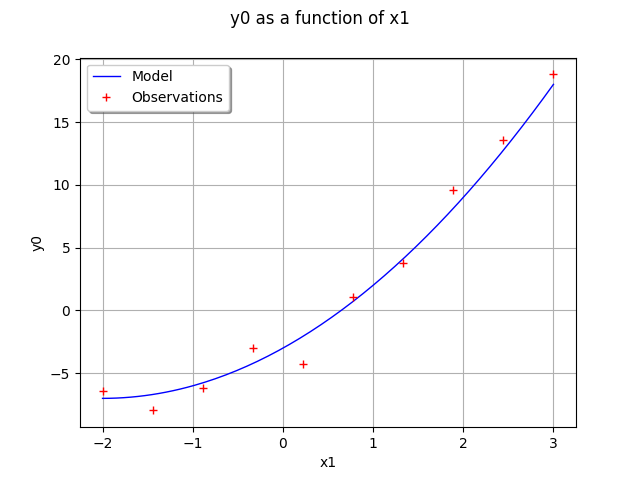

In [8]:
functionnalModel = ot.ParametricFunction(fullModel, [1,2,3], thetaPriorMean)
graphModel = functionnalModel.getMarginal(0).draw(xmin,xmax)
observations = ot.Cloud(x_obs,y_obs)
observations = ot.Cloud(x_obs,y_obs)
observations.setColor("red")
graphModel.add(observations)
graphModel.setLegends(["Model","Observations"])
graphModel.setLegendPosition("topleft")
graphModel

- Define the distribution of observations $\underline{y} | \underline{z}$ conditional on model predictions

Note that its parameter dimension is the one of $\underline{z}$, so the model must be adjusted accordingly

In [9]:
conditional = ot.Normal()
conditional

class=Normal name=Normal dimension=1 mean=class=Point name=Unnamed dimension=1 values=[0] sigma=class=Point name=Unnamed dimension=1 values=[1] correlationMatrix=class=CorrelationMatrix dimension=1 implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[1]

- Define the the prior distribution $\pi(\underline{\theta})$ of the parameter $\underline{\theta}$

In [10]:
sigma0 = ot.Point([2.,1.,1.5])  # standard deviations
thetaPriorCovarianceMatrix = ot.CovarianceMatrix(paramDim)
for i in range(paramDim):
    thetaPriorCovarianceMatrix[i, i] = sigma0[i]**2

prior = ot.Normal(thetaPriorMean, thetaPriorCovarianceMatrix)
prior.setDescription(['p1', 'p2', 'p3'])
prior

class=Normal name=Normal dimension=3 mean=class=Point name=Unnamed dimension=3 values=[-3,4,1] sigma=class=Point name=Unnamed dimension=3 values=[2,1,1.5] correlationMatrix=class=CorrelationMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[1,0,0,0,1,0,0,0,1]

- Proposal distribution: uniform.

In [11]:
proposal = [ot.Uniform(-1., 1.)] * paramDim
proposal

[class=Uniform name=Uniform dimension=1 a=-1 b=1,
 class=Uniform name=Uniform dimension=1 a=-1 b=1,
 class=Uniform name=Uniform dimension=1 a=-1 b=1]

## Test the MCMC sampler

In [14]:
mymcmc = ot.MCMC(prior, conditional, model, x_obs, y_obs, thetaPriorMean)

In [15]:
mymcmc.computeLogLikelihood(thetaPriorMean)

-19.03347504261271

## Test the Metropolis-Hastings sampler

- Creation of the Random Walk Metropolis-Hastings (RWMH) sampler.

In [16]:
initialState = thetaPriorMean

In [17]:
RWMHsampler = ot.RandomWalkMetropolisHastings(
    prior, conditional, model, x_obs, y_obs, initialState, proposal)

In [18]:
RWMHsampler.computeLogLikelihood(initialState)

-19.03347504261271

In [19]:
for i in range(10):
    print(RWMHsampler.getRealization())

[-3,4.17723,1]
[-3,4.17723,1]
[-3,4.17723,0.979549]
[-3,4.17723,0.979549]
[-3,4.17723,0.979549]
[-3,4.33754,0.979549]
[-3,4.1239,0.979549]
[-3,4.1239,0.979549]
[-3,4.1239,0.979549]
[-3.03402,4.1239,0.979549]


Tuning of the RWMH algorithm.

Strategy of calibration for the random walk (trivial example: default).

In [20]:
strategy = ot.CalibrationStrategyCollection(paramDim)
RWMHsampler.setCalibrationStrategyPerComponent(strategy)

Other parameters.

In [21]:
RWMHsampler.setVerbose(True)
RWMHsampler.setThinning(1)
RWMHsampler.setBurnIn(2000)

Ready to generate a sample from the posterior distribution of the parameters theta.

In [22]:
sampleSize = 10000
sample = RWMHsampler.getSample(sampleSize)

Look at the acceptance rate (basic checking of the efficiency of the tuning; value close to 0.2 usually recommended).

In [23]:
RWMHsampler.getAcceptanceRate()

class=Point name=Unnamed dimension=3 values=[0.451873,0.298834,0.134388]

Build the distribution of the posterior by kernel smoothing.

In [24]:
sample = RWMHsampler.getSample(1000)
kernel = ot.KernelSmoothing()
posterior = kernel.build(sample)

Display prior vs posterior for p1, the first parameter of the model.

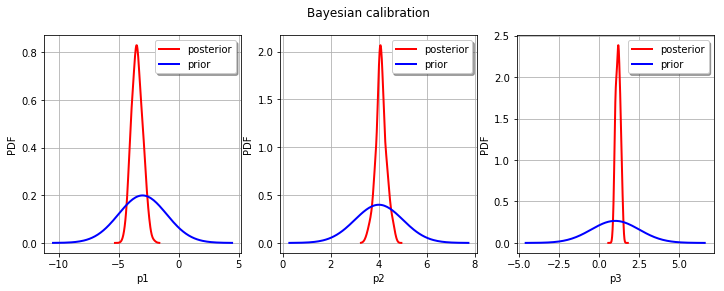

In [25]:
from openturns.viewer import View
import pylab as pl

fig = pl.figure(figsize=(12, 4))

for parameter_index in range(paramDim):
    graph = posterior.getMarginal(parameter_index).drawPDF()
    priorGraph = prior.getMarginal(parameter_index).drawPDF()
    priorGraph.setColors(['blue'])
    graph.add(priorGraph)
    graph.setLegends(['posterior', 'prior'])
    graph.setTitle('p%d parameter calibration' % (parameter_index + 1))
    ax = fig.add_subplot(1, paramDim, parameter_index+1)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])

_ = fig.suptitle("Bayesian calibration")